/var/folders/j3/fb9w9g7s1vqdx2y5by7m63180000gp/T/ipykernel_49689/1612112899.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(DATA_DIR/"out

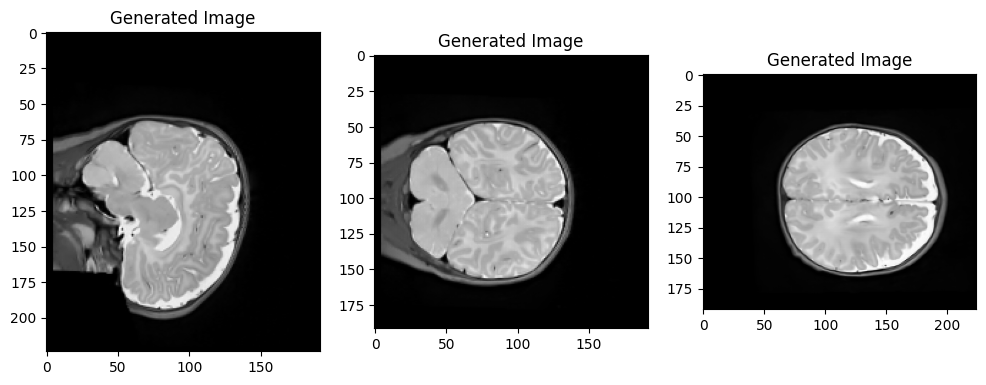

TypeError: pad_to_shape() missing 1 required positional argument: 'target_shape'

In [ ]:
#TEST ONE IMAGE
import pathlib as p
from functions import *
import nibabel as nib
import numpy as np
import random
import torch
from monai.networks.nets import UNet
from monai.networks.layers.factories import Norm
import matplotlib.pyplot as plt

#Parameters
patch_size = (32,32,32)
stride = (16,16,16)
target_shape = (192,224,192)

#Load files
DATA_DIR = p.Path.home()/"data"/"bobsrepository"
axial = DATA_DIR/"LR_data"/"axial"/"even"
t1_files = sorted(DATA_DIR.rglob("*T1w.nii.gz"))
t2_files = sorted(DATA_DIR.rglob("*T2w.nii.gz"))
t2_LR_files = sorted(axial.rglob("*T2w_LR.nii.gz"))

#reassure correct shape and voxel size
assert nib.load(t1_files[0]).shape == nib.load(t2_files[0]).shape == nib.load(t2_LR_files[0]).shape == (182,218,182)
assert nib.load(t1_files[0]).header.get_zooms() == nib.load(t2_files[0]).header.get_zooms() == nib.load(t2_LR_files[0]).header.get_zooms() == (1.0,1.0,1.0)

t1_patches = get_patches_single_img(t1_files[0], patch_size, stride, target_shape)
t2_lr_patches = get_patches_single_img(t2_LR_files[0], patch_size, stride, target_shape)


#Test deeper unet

net = UNet(
    spatial_dims=3,
    in_channels=2,
    out_channels=1,
    channels=(32, 64, 128, 256, 512, 1024),
    strides=(2, 2, 2, 2, 2),
    num_res_units=10, 
    norm=None,
)
net.load_state_dict(torch.load(DATA_DIR/"outputs"/"2025-12-10T15:25:46.850860_model_weights.pth", map_location="cpu"))

all_outputs = []
net.eval()
with torch.no_grad():
    for i in range(len(t1_patches)-1):
        input1 = torch.tensor(t1_patches[i]).float()
        input2 = torch.tensor(t2_lr_patches[i]).float()
        inputs = torch.stack([input1, input2], dim=0).unsqueeze(0)  # (1, 2, 32, 32, 32)
        output = net(inputs)
        all_outputs.append(output.squeeze(0).squeeze(0).cpu().numpy())  # (32, 32, 32)
    gen_reconstructed = reconstruct_from_patches(all_outputs, target_shape, stride)

#Visualize result:

mid_slice = target_shape[0] // 2
plt.figure(figsize=(12, 8))
plt.subplot(1,3,1)
plt.title("Generated Image")
plt.imshow(gen_reconstructed[mid_slice,:,:], cmap='gray')
plt.subplot(1,3,2)
plt.title("Generated Image")
plt.imshow(gen_reconstructed[:,mid_slice,:], cmap='gray')
plt.subplot(1,3,3)
plt.title("Generated Image")
plt.imshow(gen_reconstructed[:,:,mid_slice], cmap='gray')
plt.show()

#Save generated image


In [ ]:

#save
affine = pad_to_shape(nib.load(t1_files[0]), target_shape).affine
gen_img_nib = nib.Nifti1Image(gen_reconstructed, affine=affine)
dir = p.Path("/Users/al1612le/images")
nib.save(gen_img_nib, dir/"session1_test1.nii.gz")



In [ ]:
#TEST ONE IMAGE
import pathlib as p
from functions import *
import nibabel as nib
import numpy as np
import random
import torch
from monai.networks.nets import UNet
from monai.networks.layers.factories import Norm
import matplotlib.pyplot as plt

#Parameters
patch_size = (32,32,32)
stride = (16,16,16)
target_shape = (192,224,192)

#Load files
DATA_DIR = p.Path.home()/"data"/"bobsrepository"
axial = DATA_DIR/"LR_data"/"axial"/"even"
t1_files = sorted(DATA_DIR.rglob("*T1w.nii.gz"))
t2_files = sorted(DATA_DIR.rglob("*T2w.nii.gz"))
t2_LR_files = sorted(axial.rglob("*T2w_LR.nii.gz"))

#reassure correct shape and voxel size
assert nib.load(t1_files[0]).shape == nib.load(t2_files[0]).shape == nib.load(t2_LR_files[0]).shape == (182,218,182)
assert nib.load(t1_files[0]).header.get_zooms() == nib.load(t2_files[0]).header.get_zooms() == nib.load(t2_LR_files[0]).header.get_zooms() == (1.0,1.0,1.0)

files = list(zip(t1_files, t2_files, t2_LR_files))
t1_patches, t2_patches, t2_lr_patches = get_patches(files, patch_size, stride, target_shape)


#Test deeper unet

net = UNet(
    spatial_dims=3,
    in_channels=2,
    out_channels=1,
    channels=(32, 64, 128, 256, 512, 1024),
    strides=(2, 2, 2, 2, 2),
    num_res_units=10, 
    norm=None,
)
net.load_state_dict(torch.load(DATA_DIR/"outputs"/"2025-12-10T15:25:46.850860_model_weights.pth", map_location="cpu"))

net.eval()
with torch.no_grad():
    for i in range(len(t1_patches)):
        all_outputs = []
        for j in range(len(t1_patches[0])):
            input1 = torch.tensor(t1_patches[i][j]).float()
            input2 = torch.tensor(t2_lr_patches[i][j]).float()
            inputs = torch.stack([input1, input2], dim=0).unsqueeze(0)  # (1, 2, 64, 64, 64)
            output = net(inputs)
            all_outputs.append(output.squeeze(0).squeeze(0).cpu().numpy())  # (64, 64, 64)
        gen_reconstructed = reconstruct_from_patches(all_outputs, target_shape, stride)
        nib.save(nib.Nifti1Image(gen_reconstructed, affine=pad_to_shape(nib.load(t1_files[0]), target_shape).affine), p.Path.home()/"session1random"/f"session1_test{i+1}.nii.gz")
        print(f"Processed and saved test image {i+1}/{len(t1_patches)}")

        


/var/folders/j3/fb9w9g7s1vqdx2y5by7m63180000gp/T/ipykernel_49689/2134133185.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(DATA_DIR/"out

Processed and saved test image 1/71
Processed and saved test image 2/71


KeyboardInterrupt: 